# Kalman Filter

Interpolation

$X_a = X_b + K(X_{obs} - HX_b)$ \
$X_{obs}-HX_b =$ Innovation Vector

$e_b = $background error $= X_t - X_b$ \
$e_a = $analysis error $= X_t - X_a$ \
$e_o = $observation error $= X_t - X_{obs}$ 

$e_a = X_t - X_a = X_t - (X_b + K(X_{obs} - HX_b) \\
=(X_t - X_b) - K(X_{obs} - HX_b) \\
= e_b - K(X_{obs} - HX_t + HX_t - HX_b) \\
= e_b - K(-e_o + He_b) \\
= (I_n - KH)e_b + Ke_0$


$e_a = (I-KH)e_b + Ke_o \\
E(e_a e_a^T) = E((I-KH)E_b + Ke_0)((I-KH)e_b + Ke_0)^T) \\
= E(((I-KH)e_b e_b^T (I-KH)^T) + E((I-KH)e_b e_o^T K^T) + E(K e_o e_b^T(I-KH)^T) + E(K e_o e_o^T K^T) \\
= (I-KH)E(e_b e_b^T)(I-KH)^T +(I-KH)E(e_b e_o^T)K^T + KE(e_o e_b^T)(I-KH)^T + KE(e_o e_o^T)K^T\\
$


We assume that $e_o$ and $e_b$ are uncorrelated \
$E(e_o e_b^T) = 0$

$P_a(k) = (I-KH)P_b(I-KH)^T + KRK^T$

Choose K that minimizes $P_a$

$P_a'(K;L) = lim_{\epsilon→0} \frac{P_a(K+\epsilon L) - P_a(K)}{\epsilon}$ \
$P_a(K+\epsilon L) = (I - (K+\epsilon L)H)P_b(I-(K+\epsilon L)H)^T \\
= (I-KH)P_b(I-KH)^T - \epsilon LHP_b(I-KH)^T - \epsilon(I-KH)P_b(LH)^T \\
+ KRK^T + \epsilon LRK^T + \epsilon KRL^T + \epsilon^2 LRL^T$

$P_a'(K;L) = -LHP_b(I-KH)^T - (I-KH)P_b(LH)^T + LRK^T + KRL^T = 0  \ \forall L$

$L(RK^T - HP_b(I-KH)^T)+(KR-(I-KH)P_b H^T)L^T = 0 \ \forall L \\
LA + A^TL^T = 0$ if $A=0$

The matrix K that minimizes $P_a$ satisfies: \
$KR - (I-KH)P_b H^T = 0 \\
KR-P_b H^T + KHP_bH^T = 0 \\
K(R + HP_bH^T) = P_b H^T　\\
→　K= P_b H^T(R+HP_bH^T)^{-1}$

Assume that R and P_b are invertible

$\underline{K = BH^T(HBH^T + R)^{-1}}$ is the **Kalman Filter(gain) matrix**

best interpolation = $X_a = X_b + K(X_{obs} - HX_b)$ \
BLUE(best linear unbiased estimator)

In dimension 1: $k = b(b+r)^{-1} = \frac{b}{b+r}$ 

$x_a = x_b + k(x_o - x_b) \\
= x_b + \frac{b}{b+r}(x_o - x_b) \\
= \frac{b x_o + r x_b}{b+r}$

In [1]:
# Lorenz model
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# model parameters (=> "chaotic" system)
s = 10.0
r = 28.0
b = 8.0/3.0

In [3]:
# time window, time step, ...
T = 5.0
N = 4000
dt = T/N

In [4]:
# observation frequency
freqobs = 100 # every 100 time steps, we have one observation

In [5]:
# solve direct model
def lorenz(X0): # X0 is a vector dimension 3
    X = np.zeros((N+1,3))
    X[0,:] = X0 # initialisation
    for i in range(N): # time loop
        X[i+1,0] = X[i,0] + dt * s*(X[i,1]-X[i,0]) # x component
        X[i+1,1] = X[i,1] + dt * (r*X[i,0]-X[i,1]-X[i,0]*X[i,2]) # y component
        X[i+1,2] = X[i,2] + dt * (X[i,0]*X[i,1]-b*X[i,2]) # z component
    return X


In [6]:
# direct simulation
X0test = np.array([-4.62,-6.61,17.94])
Xtest = lorenz(X0test)

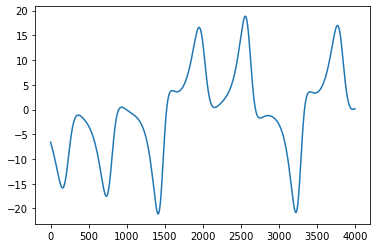

In [7]:
# plot solution
plt.plot(Xtest[:,1])

In [8]:
# twin experiments: we generate our observations from our model and a known initial condition
Xobs = lorenz(X0test)
# possibly add noise
noise = np.random.randn(N+1,3)
noiselevel = 1.0
###noiselevel = 0.0
Xobs = Xobs + noiselevel*noise
# from now, use Xobs at some particular (observation) times, and try to recover X0test
# assume we observe everything => H = Id
R = noiselevel*np.identity(3)
Rinv = np.linalg.inv(R)
###Rinv = np.identity(3)

In [9]:
# background solution:
Xb0 = np.array([-4.0,-6.0,18.0])
###Xb0 = X0test
Xb = lorenz(Xb0) # the trajectory we get without data assimilation
B = np.identity(3)
Binv = np.linalg.inv(B)

In [10]:
# Kalman
def kalman(X0): # X0 is a vector dimension 3
    X = np.zeros((N+1,3))
    X[0,:] = X0 # initialisation
    Pf = B # initialisation
    for i in range(N): # time loop
        # solution update
        X[i+1,0] = X[i,0] + dt * s*(X[i,1]-X[i,0]) # x component
        X[i+1,1] = X[i,1] + dt * (r*X[i,0]-X[i,1]-X[i,0]*X[i,2]) # y component
        X[i+1,2] = X[i,2] + dt * (X[i,0]*X[i,1]-b*X[i,2]) # z component
        # covariance matrices update
#        newPf = one step of TLM * oldPf * one step adjoint model
        # if observation time
        if np.mod(i+1,freqobs) == 0:
            # analysis
            # Kalman matrix
            K = np.matmul(Pf,np.linalg.inv(Pf+R)) #Pf*(Pf+R)^-1
            # analysis
            Xa = X[i+1,:]+K.dot(Xobs[i+1,:]-X[i+1,:])
            X[i+1,:] = Xa
    return X


In [11]:
Xtest = kalman(X0test)

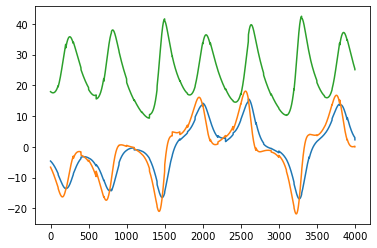

In [12]:
plt.plot(Xtest)